# Scaler dataframe for Auger Open Data 
### A Neutron Monitor Comparison

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import augerscalerpy.plot_config as pc
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data ## ESTA SÍ ESSSSS LA FORMAAAAAAAAAAA!!!!!!!!


In [35]:
NM = pd.read_csv('NM.csv')
NM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01 00:00:00,324.971,54.535,217.712,148.928,101.445
1,2006-01-02 00:00:00,325.676,54.639,219.248,149.769,102.270
2,2006-01-03 00:00:00,325.625,54.759,219.858,150.274,102.841
3,2006-01-04 00:00:00,325.846,54.859,219.925,150.447,103.335
4,2006-01-05 00:00:00,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27 00:00:00,null,56.098,229.513,127.708,111.792
5657,2021-06-28 00:00:00,null,55.974,228.834,127.550,111.660
5658,2021-06-29 00:00:00,null,56.076,228.892,127.555,111.742
5659,2021-06-30 00:00:00,null,56.167,229.522,128.031,111.810


## Bases de datos disponibles

#### https://www.nmdb.eu/nest/
#### https://cidas.isee.nagoya-u.ac.jp/WDCCR/station_list.php
#### Las páginas oficiales de las estaciones: http://cr0.izmiran.ru/common/
#### El servicio de IZMIRAN http://cr0.izmiran.ru/rome/main.htm


In [97]:
#### ES UN DATO POR DÍA

cutNM = NM[NM['DATE'] >= "2006-01-01"]
cutfNM = cutNM[cutNM['DATE'] <= "2021-12-30" ]

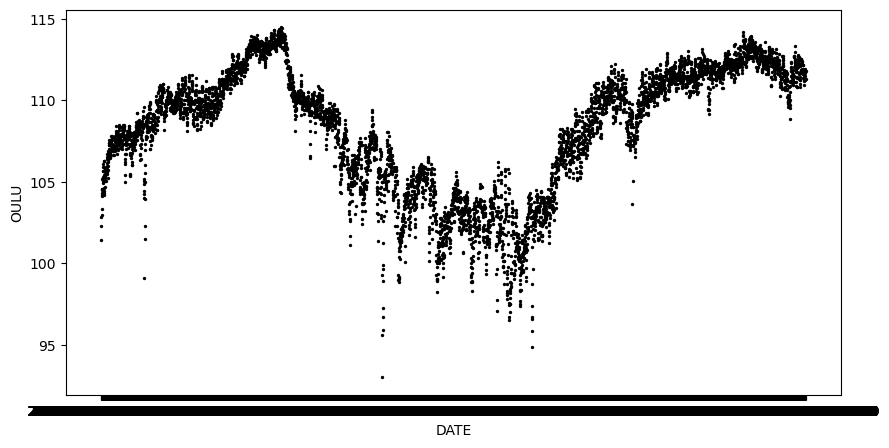

In [98]:
cutfNM.plot(kind='scatter', s= 2, x='DATE',y='OULU', figsize=(10, 5),color='black')
plt.show()

In [99]:
#replacing NaN values

#rigcut['TSMB'] = rigcut['TSMB'].fillna(0)
#cutfNM = cutfNM.fillna(0)
#cutfNM = cutfNM.replace(to_replace = '   null', value = 0.00)
#cutfNM.interpolate(inplace=True)
cutfNM.replace('   null', np.nan, inplace=True)

In [100]:
cutfNM.interpolate(inplace=True)

/tmp/ipykernel_11007/455035404.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  cutfNM.interpolate(inplace=True)


In [101]:
# ADDING SCALER DATASET
scaler3600s = scaler_clean('scaler_ALL_hourly_11abril.csv','scaler_hourly')

Hay  (11805, 4) líneas vacías


In [102]:
newrg = pd.to_datetime(cutfNM['DATE'])
cutfNM["DATE"] = newrg.values
cutfNM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,NaN,56.098,229.513,127.708,111.792
5657,2021-06-28,NaN,55.974,228.834,127.550,111.660
5658,2021-06-29,NaN,56.076,228.892,127.555,111.742
5659,2021-06-30,NaN,56.167,229.522,128.031,111.810


In [103]:
cutfNM["TSMB"] = cutfNM["TSMB"].astype(float)
cutfNM["ATHN"] = cutfNM["ATHN"].astype(float)
cutfNM["MXCO"] = cutfNM["MXCO"].astype(float)
cutfNM["ROME"] = cutfNM["ROME"].astype(float)
cutfNM["OULU"] = cutfNM["OULU"].astype(float)

In [104]:
cutfNM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,NaN,56.098,229.513,127.708,111.792
5657,2021-06-28,NaN,55.974,228.834,127.550,111.660
5658,2021-06-29,NaN,56.076,228.892,127.555,111.742
5659,2021-06-30,NaN,56.167,229.522,128.031,111.810


In [106]:
cantidad_nan_por_columna = cutfNM.isna().sum()
cantidad_nan_por_columna

DATE       0
TSMB    1226
ATHN     121
MXCO     120
ROME     843
OULU       0
dtype: int64

In [107]:
rgnan = cutfNM.fillna(0)
rgnan

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,0.000,56.098,229.513,127.708,111.792
5657,2021-06-28,0.000,55.974,228.834,127.550,111.660
5658,2021-06-29,0.000,56.076,228.892,127.555,111.742
5659,2021-06-30,0.000,56.167,229.522,128.031,111.810


In [111]:
NZV = rgnan[(rgnan.iloc[:, 1:] != 0).all(axis=1)]
NZV

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
4991,2019-09-01,336.306,56.119,230.093,127.659,110.785
5126,2020-01-14,332.429,45.615,230.208,128.106,112.535
5127,2020-01-15,332.429,45.546,229.886,127.927,112.390
5173,2020-03-01,332.429,45.623,230.531,128.278,112.762


In [112]:
# Calcular el promedio de cada columna numérica excepto 'DATE'
columnas_numericas = NZV.columns[NZV.dtypes == 'float64']
promedios = NZV[columnas_numericas].mean()

# Normalizar cada columna dividiendo por su promedio
NZV[columnas_numericas] = NZV[columnas_numericas] / promedios
NZV

/tmp/ipykernel_11007/3626205203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NZV[columnas_numericas] = NZV[columnas_numericas] / promedios


,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,0.983099,0.969611,0.962983,0.995841,0.945656
1,2006-01-02,0.985232,0.971460,0.969777,1.001464,0.953347
2,2006-01-03,0.985077,0.973594,0.972475,1.004841,0.958669
3,2006-01-04,0.985746,0.975372,0.972772,1.005998,0.963274
4,2006-01-05,0.984956,0.976047,0.971768,1.005530,0.959797
...,...,...,...,...,...,...
4991,2019-09-01,1.017389,0.997774,1.017747,0.853621,1.032722
5126,2020-01-14,1.005661,0.811017,1.018255,0.856610,1.049036
5127,2020-01-15,1.005661,0.809790,1.016831,0.855413,1.047684
5173,2020-03-01,1.005661,0.811159,1.019684,0.857760,1.051152


<AxesSubplot:xlabel='DATE'>

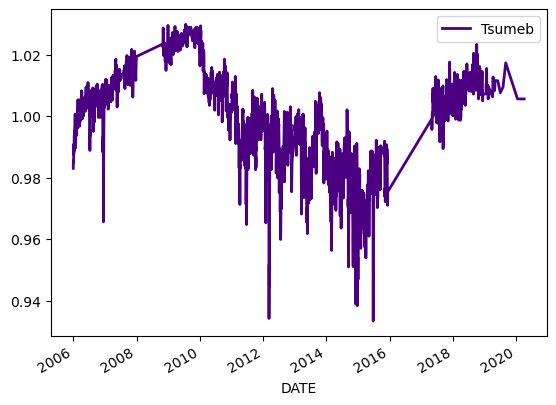

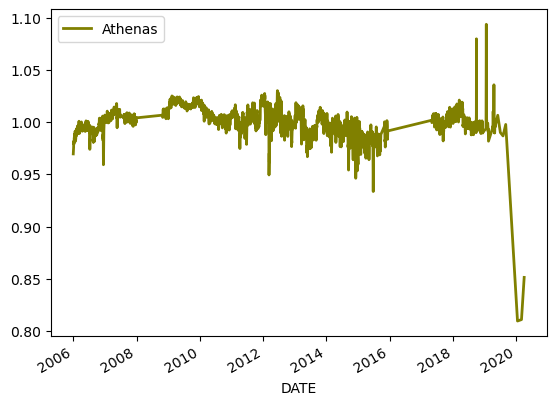

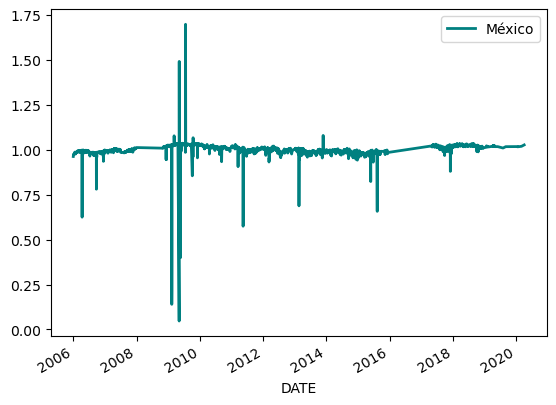

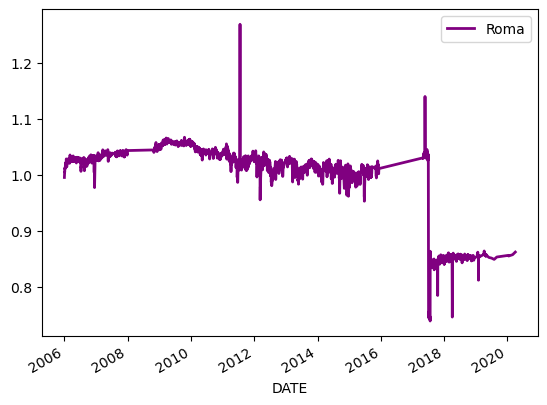

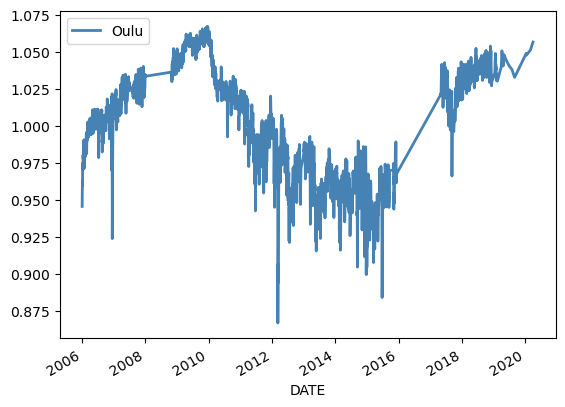

In [113]:
## La mayoría de estaciones son una porquería... esa e sla razón por la que todo el mundo usa Oulu
NZV.plot(x='DATE',y='TSMB',color='indigo',rot=30,linewidth =2, label ="Tsumeb")
NZV.plot(x='DATE',y='ATHN',color='olive',rot=30,linewidth =2, label ="Athenas")
NZV.plot(x='DATE',y='MXCO',color='teal',rot=30,linewidth =2, label ="México")
NZV.plot(x='DATE',y='ROME',color='purple',rot=30,linewidth =2, label ="Roma")
NZV.plot(x='DATE',y='OULU',color='steelblue',rot=30,linewidth =2, label ="Oulu")

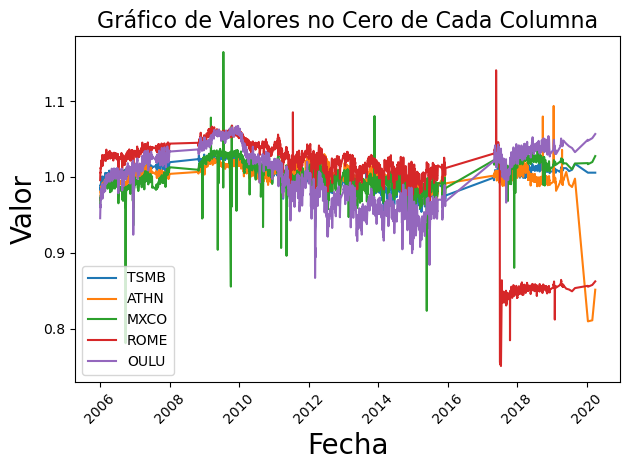

In [115]:
#rgnan.plot(x='DATE',y='TSMB',color='indigo',rot=30,linewidth =2, label ="Tsumeb")
#rgnan.plot(x='DATE',y='ATHN',color='olive',rot=30,linewidth =2, label ="Athenas")
#rgnan.plot(x='DATE',y='MXCO',color='teal',rot=30,linewidth =2, label ="México")
#rgnan.plot(x='DATE',y='ROME',color='purple',rot=30,linewidth =2, label ="Roma")
#rgnan.plot(x='DATE',y='OULU',color='steelblue',rot=30,linewidth =2, label ="Oulu")


# Configura los valores de fecha que deseas mostrar en el eje x
#dates_to_show = ["2011-02-17", "2011-02-19", "2011-02-21"]
# Configura el formato de las etiquetas del eje x
#plt.figsize=(10, 8)

# Convertir las columnas seleccionadas en matrices NumPy
columns_to_plot = NZV.columns[1:]  # Excluye la columna 'DATE'
data_to_plot = NZV[columns_to_plot].to_numpy()

# Obtener las fechas como un arreglo NumPy
fechas = NZV['DATE'].to_numpy()

# Graficar todas las columnas superpuestas
#for i in range(data_to_plot.shape[1]):
#    ax.plot(fechas, data_to_plot[:, i], label=columns_to_plot[i])
for column in NZV.columns[1:]:
    non_zero_values = NZV[(NZV[column] != 0) & (NZV[column] <= 1.25) & (NZV[column] > 0.75)]
    plt.plot(non_zero_values['DATE'].values, non_zero_values[column].values, label=column)

# Configurar etiquetas y leyendas
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Valor', fontsize=20)
plt.title('Gráfico de Valores no Cero de Cada Columna', fontsize=16)
plt.legend()

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()




#### CONCLUSIÓN TRABAJAREMOS CON OULU

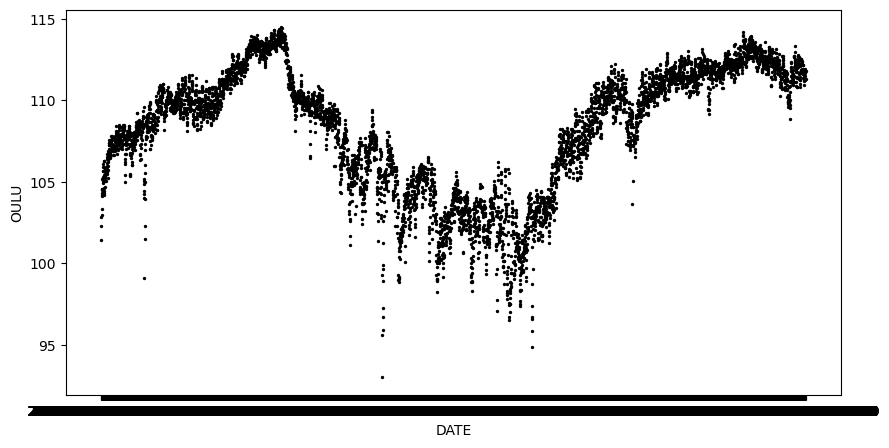

In [13]:
NM.plot(kind='scatter', s= 2, x='DATE',y='OULU', figsize=(10, 5),color='black')
plt.savefig("OULU_variations.png")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='both', labelsize=15)
plt.plot(rgnan['DATE'], ((rgnan['auger'])*0.4)-250, "r", label='Auger (Scaled)')
#plt.plot(rgnan['DATE'], rgnan['MXCO'], "b", label='México')
plt.plot(rgnan['DATE'], rgnan['TSMB']+50, "b", label='Tsumeb')
#plt.plot(rgnan['DATE'], rgnan['ATHN']+260, "g", label='Athenas')
plt.plot(rgnan['DATE'], rgnan['OULU']+250, "m", label='Oulu')

#plt.plot(eventoFDD['YYYY.MM.DD'], ((eventoFDD['imp/min']*0.18)-510)/1640, "black", label='Tsumeb')
#plt.plot(data[:,3], data[:,0], "r")
plt.xlabel("Year",fontsize=16)
plt.ylabel("Rate",fontsize=16)
plt.legend()
plt.savefig('scaler_vs_NM.png')

plt.show()

In [119]:
scaler3600s['Date'] = pd.to_datetime(scaler3600s['Date'])
scaler3600s.set_index('Date', inplace=True)

KeyError: 'Date'

In [118]:
# Paso 1: Convertir la columna 'Date' en un índice DatetimeIndex
scaler3600s['Date'] = pd.to_datetime(scaler3600s['Date'])
scaler3600s.set_index('Date', inplace=True)

# Paso 2: Resample a una frecuencia diaria (tomando el primer valor de cada día)
scaler3600s_daily = scaler3600s.resample('D').first()

# Paso 3: Calcular el promedio diario ignorando los valores cero
scaler3600s_daily_mean = scaler3600s_daily.apply(lambda x: x[x != 0].mean(), axis=1)

# Puedes reemplazar los valores cero en el dataframe original con el promedio calculado
scaler3600s_cleaned = scaler3600s.copy()
scaler3600s_cleaned['ScalerCorr'] = scaler3600s_cleaned.apply(lambda x: scaler3600s_daily_mean[x.name], axis=1)

scaler3600s_cleaned

KeyError: Timestamp('2006-01-01 00:29:46')